In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/datasets")
os.chdir("C:/diego_tools/labo3/dataset")
####################################################

In [3]:
def error_rate(y, y_pred):
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    
    return round(100*dif_abs/suma_real,2)

def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = error_rate(preds, labels)
    return 'ER', ret_val, False

In [4]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

In [5]:
df_sellout = pd.read_csv("emp3_sellout_product_train.csv")

In [6]:
df_sellout.head()

,product_id,periodo,imputado,tn,cust_request_tn,cust_request_qty,plan_precios_cuidados,periodo_fecha,mes,cat1,...,cat2_tn_delta_2,cat2_tn_lag_3,cat2_tn_delta_3,cat3_tn,cat3_tn_lag_1,cat3_tn_delta_1,cat3_tn_lag_2,cat3_tn_delta_2,cat3_tn_lag_3,cat3_tn_delta_3
0,20001,201701,0,934.77222,937.72717,479.0,0.0,2017-01-01,1,HC,...,NaN,NaN,NaN,3871.38669,NaN,NaN,NaN,NaN,NaN,NaN
1,20002,201701,0,550.15707,555.18654,391.0,0.0,2017-01-01,1,HC,...,NaN,NaN,NaN,3871.38669,NaN,NaN,NaN,NaN,NaN,NaN
2,20009,201701,0,378.08172,380.53217,429.0,0.0,2017-01-01,1,HC,...,NaN,NaN,NaN,3871.38669,NaN,NaN,NaN,NaN,NaN,NaN
3,20015,201701,0,304.24755,307.99005,374.0,0.0,2017-01-01,1,HC,...,NaN,NaN,NaN,3871.38669,NaN,NaN,NaN,NaN,NaN,NaN
4,20026,201701,0,184.40020,185.10637,307.0,0.0,2017-01-01,1,HC,...,NaN,NaN,NaN,3871.38669,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30825 entries, 0 to 30824
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 30825 non-null  int64  
 1   periodo                    30825 non-null  int64  
 2   imputado                   30825 non-null  int64  
 3   tn                         30825 non-null  float64
 4   cust_request_tn            30825 non-null  float64
 5   cust_request_qty           30825 non-null  float64
 6   plan_precios_cuidados      30825 non-null  float64
 7   periodo_fecha              30825 non-null  object 
 8   mes                        30825 non-null  int64  
 9   cat1                       30825 non-null  object 
 10  cat2                       30825 non-null  object 
 11  cat3                       30825 non-null  object 
 12  brand                      30825 non-null  object 
 13  sku_size                   30825 non-null  flo

In [8]:
df_sellout.isna().sum()

product_id                      0
periodo                         0
imputado                        0
tn                              0
cust_request_tn                 0
cust_request_qty                0
plan_precios_cuidados           0
periodo_fecha                   0
mes                             0
cat1                            0
cat2                            0
cat3                            0
brand                           0
sku_size                        0
producto_estrella               0
temp_media                      0
temp_max_media                  0
temp_min_media                  0
IPC                             0
promedio_mens_dolar_venta       0
catastrofe                      0
accion                          0
dif_cust_request_tn             0
dif_cust_request_tn_porc        0
tn_lag_1                     1233
tn_lag_2                     2466
tn_lag_3                     3699
tn_mas_2                        0
tn_delta_1                   1233
tn_delta_2    

In [9]:
#Transformo todas las categoricas
categories = ["plan_precios_cuidados","cat1","cat2","cat3","product_id","producto_estrella","catastrofe"]

for c in categories: 
    df_sellout[c] = df_sellout[c].astype("category")   
    
#Elimino otras variables
df_sellout = df_sellout.drop(columns=["brand","periodo_fecha","imputado"])

In [10]:
df_sellout.periodo.head()

0    201701
1    201701
2    201701
3    201701
4    201701
Name: periodo, dtype: int64

In [11]:
df_train = df_sellout[df_sellout.accion == "train"]
df_holdout = df_sellout[df_sellout.accion == "holdout"]

df_train.periodo.unique(),df_holdout.periodo.unique()

(array([201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708,
        201709, 201710, 201711, 201712, 201801, 201802, 201803, 201804,
        201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812],
       dtype=int64),
 array([201902], dtype=int64))

In [31]:
X_train = df_train.drop(columns=["tn_mas_2","periodo","accion"], axis=1)
X_holdout = df_holdout.drop(columns=["tn_mas_2","periodo","accion"], axis=1)

y_train = df_train.tn_mas_2
y_holdout = df_holdout.tn_mas_2

y_train.shape, X_train.shape, y_holdout.shape, X_holdout.shape

((29592,), (29592, 46), (1233,), (1233, 46))

In [32]:
lgb_params = {'num_leaves': 100,
              'learning_rate': 0.1,
              'feature_fraction': 0.8,
              'n_estimators': 400,
              'max_depth': -1,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 500,
              'nthread': -1}

In [33]:
cols = X_train.columns.tolist()

lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
lgb_holdout = lgb.Dataset(data=X_holdout, label=y_holdout, reference=lgb_train, feature_name=cols)

In [34]:
model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_holdout],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_error_rate,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003910 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 500 rounds
[100]	valid_0's l2: 458.381	valid_0's ER: 27.61
[200]	valid_0's l2: 460.46	valid_0's ER: 27.75
[300]	valid_0's l2: 460.151	valid_0's ER: 27.77
[400]	valid_0's l2: 459.22	valid_0's ER: 27.8
Did not meet early stopping. Best iteration is:
[74]	valid_0's l2: 452.703	valid_0's ER: 27.6


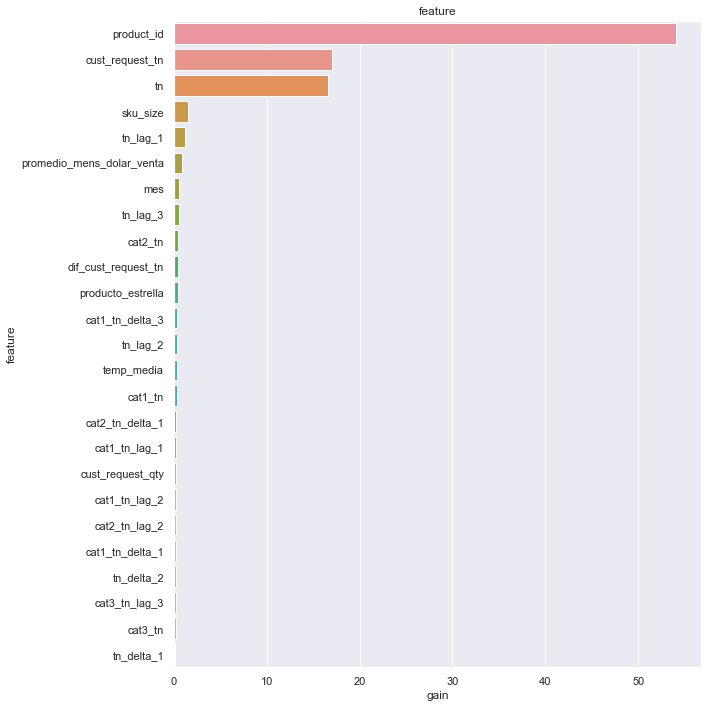

,feature,split,gain
0,product_id,530,54.075360
2,cust_request_tn,263,16.984733
1,tn,301,16.585916
9,sku_size,155,1.554953
19,tn_lag_1,350,1.169878
15,promedio_mens_dolar_venta,220,0.897915
5,mes,189,0.586022
21,tn_lag_3,310,0.544068
32,cat2_tn,149,0.472726
17,dif_cust_request_tn,287,0.447789


In [35]:
plot_lgb_importances(model, num=30, plot=True)

In [36]:
y_pred = model.predict(X_holdout)

In [37]:
error_rate(y_holdout,y_pred)

27.24

In [38]:
len(X_holdout)

1233

In [39]:
print(X_holdout.shape)
df_prediction = X_holdout
df_prediction["tn_target"]=y_holdout
df_prediction["tn_predicted"]=y_pred
print(df_prediction.shape)

(1233, 46)
(1233, 48)


In [26]:
df_prediction.to_csv("emp3_lightgbm_prediction.csv", index=False)